In [1]:
%matplotlib inline

import tensorflow_datasets as tfds
import tensorflow as tf

import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

In [2]:
examples, metadata = tfds.load(
    'ted_hrlr_translate/pt_to_en',
    data_dir='./tfds',
    with_info=True, as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

examples.keys(), metadata

(dict_keys(['test', 'train', 'validation']), tfds.core.DatasetInfo(
     name='ted_hrlr_translate',
     version=0.0.1,
     description='Data sets derived from TED talk transcripts for comparing similar language pairs
 where one is high resource and the other is low resource.
 ',
     homepage='https://github.com/neulab/word-embeddings-for-nmt',
     features=Translation({
         'en': Text(shape=(), dtype=tf.string),
         'pt': Text(shape=(), dtype=tf.string),
     }),
     total_num_examples=54781,
     splits={
         'test': 1803,
         'train': 51785,
         'validation': 1193,
     },
     supervised_keys=('pt', 'en'),
     citation="""@inproceedings{Ye2018WordEmbeddings,
       author  = {Ye, Qi and Devendra, Sachan and Matthieu, Felix and Sarguna, Padmanabhan and Graham, Neubig},
       title   = {When and Why are pre-trained word embeddings useful for Neural Machine Translation},
       booktitle = {HLT-NAACL},
       year    = {2018},
       }""",
     redistrib

In [3]:
next(iter(train_examples))

(<tf.Tensor: id=168, shape=(), dtype=string, numpy=b'os astr\xc3\xb3nomos acreditam que cada estrela da gal\xc3\xa1xia tem um planeta , e especulam que at\xc3\xa9 um quinto deles tem um planeta do tipo da terra que poder\xc3\xa1 ter vida , mas ainda n\xc3\xa3o vimos nenhum deles .'>,
 <tf.Tensor: id=169, shape=(), dtype=string, numpy=b"astronomers now believe that every star in the galaxy has a planet , and they speculate that up to one fifth of them have an earth-like planet that might be able to harbor life , but we have n't seen any of them .">)

In [4]:
tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_examples),
    target_vocab_size=2**13)

tokenizer_pt = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples),
    target_vocab_size=2**13)

In [5]:
sample_string = 'Transformer is awesome.'

tokenized_string = tokenizer_en.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_en.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

for ts in tokenized_string:
    print ('{} ----> {}'.format(ts, tokenizer_en.decode([ts]).replace(' ', '_')))

Tokenized string is [7915, 1248, 7946, 7194, 13, 2799, 7877]
The original string: Transformer is awesome.
7915 ----> T
1248 ----> ran
7946 ----> s
7194 ----> former_
13 ----> is_
2799 ----> awesome
7877 ----> .


In [6]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64
MAX_LENGTH = 40


def encode(lang1, lang2, tok1=tokenizer_pt, tok2=tokenizer_en):
    lang1 = [tok1.vocab_size] + \
        tok1.encode(lang1.numpy()) + \
        [tok1.vocab_size+1]

    lang2 = [tok2.vocab_size] + \
        tok2.encode(lang2.numpy()) + \
        [tok2.vocab_size+1]
  
    return lang1, lang2

def filter_max_length(x, y, max_length=MAX_LENGTH):
    return tf.logical_and(tf.size(x) <= max_length,
                          tf.size(y) <= max_length)

def tf_encode(pt_sent, en_sent):
    return tf.py_function(
        encode,
        [pt_sent, en_sent],
        [tf.int64, tf.int64]
    )

train_dataset = train_examples\
    .map(tf_encode)\
    .filter(filter_max_length)\
    .cache()\
    .shuffle(BUFFER_SIZE)\
    .padded_batch(BATCH_SIZE, padded_shapes=([-1], [-1]))\
    .prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = val_examples\
    .map(tf_encode)\
    .filter(filter_max_length)\
    .padded_batch(BATCH_SIZE, padded_shapes=([-1], [-1]))

pt_batch, en_batch = next(iter(val_dataset))
pt_batch, en_batch

(<tf.Tensor: id=207695, shape=(64, 40), dtype=int64, numpy=
 array([[8214, 1259,    5, ...,    0,    0,    0],
        [8214,  299,   13, ...,    0,    0,    0],
        [8214,   59,    8, ...,    0,    0,    0],
        ...,
        [8214,   95,    3, ...,    0,    0,    0],
        [8214, 5157,    1, ...,    0,    0,    0],
        [8214, 4479, 7990, ...,    0,    0,    0]])>,
 <tf.Tensor: id=207696, shape=(64, 40), dtype=int64, numpy=
 array([[8087,   18,   12, ...,    0,    0,    0],
        [8087,  634,   30, ...,    0,    0,    0],
        [8087,   16,   13, ...,    0,    0,    0],
        ...,
        [8087,   12,   20, ...,    0,    0,    0],
        [8087,   17, 4981, ...,    0,    0,    0],
        [8087,   12, 5453, ...,    0,    0,    0]])>)

(1, 50, 512)


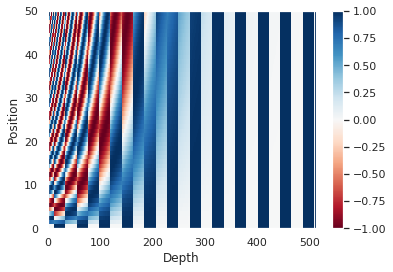

In [7]:
# positional encoding - look into this more

def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates


def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)


pos_encoding = positional_encoding(50, 512)
print(pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

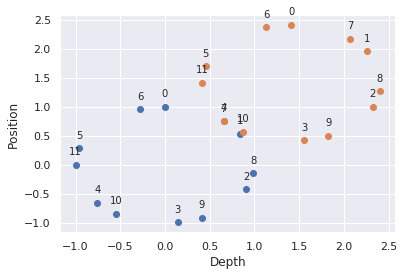

In [8]:
d2_pos_encoding = positional_encoding(12, 2)[0]
added = np.array([1.414, 1.414]) + d2_pos_encoding.numpy()

plt.plot(d2_pos_encoding[:, 0], d2_pos_encoding[:, 1], 'o')
for i, xy in enumerate(d2_pos_encoding):
    xy = (float(xy[0]), float(xy[1]))
    label = f'{i}' #': ({xy[0]:.2f}, {xy[1]:.2f})'
    plt.annotate(
        label,
        xy,
        textcoords='offset points',
        xytext=(0, 10),
        ha='center')

plt.plot(added[:, 0], added[:, 1], 'o')
for i, xy in enumerate(added):
    xy = (float(xy[0]), float(xy[1]))
    label = f'{i}' #': ({xy[0]:.2f}, {xy[1]:.2f})'
    plt.annotate(
        label,
        xy,
        textcoords='offset points',
        xytext=(0, 10),
        ha='center')

plt.xlabel('Depth')
plt.ylabel('Position')
plt.show()

In [9]:
# padding mask

def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)


<tf.Tensor: id=207924, shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [10]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: id=207939, shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

In [11]:
def qk(q, k):
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # Q * K^T
    
    # scale that bitch
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    return matmul_qk / tf.math.sqrt(dk)  # (Q * K^T / sqrt(dk))

def scaled_dotproduct_attention(q, k, v, mask=None):
    """Calculate attention weights
    q, k, v must have matching leading dims
    k, v must have matching penultimate dimension

    mask has different shapes depending on its type (padding or look ahead)
    but it must be broadcastable for addition. WHAT DOES THAT MEAN WHAT
    
    Args:
        q: query shape == (.., seq_len_q, depth)
        k: key shape == (.., seq_len_k, depth)
        v: value shape == (.., seq_len_v, depth_v) where seq_len_k == seq_len_v
        mask: float tensor with shape broadcastable
              to (.., seq_len_q, seq_len_k). Defaults to None
    
    Returns:
        output, attention_weights
    """
    scaled_attention_logits = qk(q, k)  # (..., seq_len_q, seq_len_k)
    
    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  # (..., seq_len_q, seq_len_k)
    
    # softmax normalized to last axis
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)
    
    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)
    
    return output, attention_weights


def print_out(q, k, v, mask=None):
    temp_out, temp_attn = scaled_dotproduct_attention(q, k, v, mask=mask)
    print("QK^T")
    print(qk(q, k))
    print("Attention weights are:")
    print(temp_attn)
    print("Output is:")
    print(temp_out)
    

np.set_printoptions(suppress=True)

temp_k = tf.constant([[[10,0,0],
                       [0,10,0],
                       [0,0,10],
                       [0,0,10]]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[[   1,0],
                       [  10,0],
                       [ 100,5],
                       [1000,6]]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[[0, 0, 10],
                       [0, 10, 0],
                       [10, 10, 0]]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

QK^T
tf.Tensor(
[[[ 0.        0.       57.735027 57.735027]
  [ 0.       57.735027  0.        0.      ]
  [57.735027 57.735027  0.        0.      ]]], shape=(1, 3, 4), dtype=float32)
Attention weights are:
tf.Tensor(
[[[0.  0.  0.5 0.5]
  [0.  1.  0.  0. ]
  [0.5 0.5 0.  0. ]]], shape=(1, 3, 4), dtype=float32)
Output is:
tf.Tensor(
[[[550.    5.5]
  [ 10.    0. ]
  [  5.5   0. ]]], shape=(1, 3, 2), dtype=float32)


In [12]:
print_out(temp_q, temp_k, temp_v, mask=np.array([0.0, 1.0, 1.0, 0.0]))

QK^T
tf.Tensor(
[[[ 0.        0.       57.735027 57.735027]
  [ 0.       57.735027  0.        0.      ]
  [57.735027 57.735027  0.        0.      ]]], shape=(1, 3, 4), dtype=float32)
Attention weights are:
tf.Tensor(
[[[0.  0.  0.  1. ]
  [0.5 0.  0.  0.5]
  [1.  0.  0.  0. ]]], shape=(1, 3, 4), dtype=float32)
Output is:
tf.Tensor(
[[[1000.     6. ]
  [ 500.5    3. ]
  [   1.     0. ]]], shape=(1, 3, 2), dtype=float32)


In [13]:
print_out(temp_q, temp_q, temp_q)

QK^T
tf.Tensor(
[[[ 57.735027   0.         0.      ]
  [  0.        57.735027  57.735027]
  [  0.        57.735027 115.470055]]], shape=(1, 3, 3), dtype=float32)
Attention weights are:
tf.Tensor(
[[[1.  0.  0. ]
  [0.  0.5 0.5]
  [0.  0.  1. ]]], shape=(1, 3, 3), dtype=float32)
Output is:
tf.Tensor(
[[[ 0.  0. 10.]
  [ 5. 10.  0.]
  [10. 10.  0.]]], shape=(1, 3, 3), dtype=float32)


In [14]:
print_out(temp_v, temp_v, temp_v)  # softmax makes attention weights bias the largest query vectors 

QK^T
tf.Tensor(
[[[     0.70710677      7.071068       70.71068       707.1068    ]
  [     7.071068       70.71068       707.1068       7071.068     ]
  [    70.71068       707.1068       7088.7456      70731.89      ]
  [   707.1068       7071.068       70731.89       707132.25      ]]], shape=(1, 4, 4), dtype=float32)
Attention weights are:
tf.Tensor(
[[[0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]
  [0. 0. 0. 1.]]], shape=(1, 4, 4), dtype=float32)
Output is:
tf.Tensor(
[[[1000.    6.]
  [1000.    6.]
  [1000.    6.]
  [1000.    6.]]], shape=(1, 4, 2), dtype=float32)


In [15]:
print_out(temp_v, temp_v, temp_v, mask=np.array([1.0, 0.0, 0.0, 1.0]))

QK^T
tf.Tensor(
[[[     0.70710677      7.071068       70.71068       707.1068    ]
  [     7.071068       70.71068       707.1068       7071.068     ]
  [    70.71068       707.1068       7088.7456      70731.89      ]
  [   707.1068       7071.068       70731.89       707132.25      ]]], shape=(1, 4, 4), dtype=float32)
Attention weights are:
tf.Tensor(
[[[0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 1. 0.]]], shape=(1, 4, 4), dtype=float32)
Output is:
tf.Tensor(
[[[100.   5.]
  [100.   5.]
  [100.   5.]
  [100.   5.]]], shape=(1, 4, 2), dtype=float32)


In [16]:
print_out(temp_v, temp_v, temp_v, mask=np.array([[
    [0.0, 0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0, 1.0],
    [0.0, 1.0, 1.0, 1.0],
    [0.0, 0.0, 0.0, 0.0],
]]))

QK^T
tf.Tensor(
[[[     0.70710677      7.071068       70.71068       707.1068    ]
  [     7.071068       70.71068       707.1068       7071.068     ]
  [    70.71068       707.1068       7088.7456      70731.89      ]
  [   707.1068       7071.068       70731.89       707132.25      ]]], shape=(1, 4, 4), dtype=float32)
Attention weights are:
tf.Tensor(
[[[0. 0. 1. 0.]
  [0. 1. 0. 0.]
  [1. 0. 0. 0.]
  [0. 0. 0. 1.]]], shape=(1, 4, 4), dtype=float32)
Output is:
tf.Tensor(
[[[ 100.    5.]
  [  10.    0.]
  [   1.    0.]
  [1000.    6.]]], shape=(1, 4, 2), dtype=float32)


In [17]:
class MultiHeadAttention(tf.keras.layers.Layer):
    """Instead of one single attention head, Q, K, and V
    are split into multiple heads because it allows the
    model to jointly attend to information at different
    positions from different representational spaces.
    
    After the split each head has a reduced dimensionality,
    so the total computation cost is the same as a single
    head attention with full dimensionality.
    """
    def __init__(self, d_model, num_heads, *args, **kwargs):
        assert d_model % num_heads == 0
        super().__init__(*args, **kwargs)
        
        self.num_heads = num_heads
        self.d_model = d_model
        self.depth = int(self.d_model / self.num_heads)
        
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        
        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth)
        Transpose the result such that the shape is
            (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        
        q = self.wq(q)  # (batch_size, seq_len_q, d_model)
        k = self.wk(k)  # (batch_size, seq_len_k, d_model)
        v = self.wv(v)  # (batch_size, seq_len_v, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
        
        # weighted_values_sum.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        weighted_values_sum, attention_weights = scaled_dotproduct_attention(
            q, k, v, mask)
        
        weighted_values_sum = tf.transpose(
            weighted_values_sum,
            perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)
        concat_weighted_values_sum = tf.reshape(
            weighted_values_sum,
            (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)
        
        output = self.dense(concat_weighted_values_sum)  # (batch_size, seq_len_q, d_model)
        return output, attention_weights

    
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
q = tf.random.uniform((1, 20, 512))  # (batch_size, query_sequence, d_model)
out, attn = temp_mha(y, k=y, q=q, mask=None)
out.shape, attn.shape

(TensorShape([1, 20, 512]), TensorShape([1, 8, 20, 60]))

In [18]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

In [19]:
class EncoderLayer(tf.keras.layers.Layer):
    """Multi-head attention and feed-forward
    with skip connections between them
    """
    
    def __init__(self, d_model, num_heads, dff, dropout=0.1,
                 *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        # workhorses
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        # used for skip-connections
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        # trix
        self.dropout1 = tf.keras.layers.Dropout(dropout)
        self.dropout2 = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, training, mask):
        weighted_x, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        weighted_x = self.dropout1(weighted_x, training=training)
        out1 = self.layernorm1(x + weighted_x)
        
        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
        
        return out2
    

sample_encoder_layer = EncoderLayer(512, 8, 2048)
sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)),
    False,
    None)

sample_encoder_layer_output.shape

TensorShape([64, 43, 512])

In [20]:
class DecoderLayer(tf.keras.layers.Layer):
    """Multi-head attention, with masked multi-head attention
    taking output from encoder layer, and feed-forward
    with skip connections between them
    """
    
    def __init__(self, d_model, num_heads, dff, dropout=0.1,
                 *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(dropout)
        self.dropout2 = tf.keras.layers.Dropout(dropout)
        self.dropout3 = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, enc_output, training,
             look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)
        
        weighted_x, attn_weights1 = self.mha1(x, x, x, look_ahead_mask)
        weighted_x = self.dropout1(weighted_x, training=training)
        out1 = self.layernorm1(x + weighted_x)
        
        weighted_enc_output, attn_weights2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)
        weighted_enc_output = self.dropout2(weighted_enc_output, training=training)
        out2 = self.layernorm2(out1 + weighted_enc_output)
        
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(out2 + ffn_output)
        
        return out3, attn_weights1, attn_weights2
        

sample_decoder_layer = DecoderLayer(512, 8, 2048)
sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output,
    False, None, None)

sample_decoder_layer_output.shape

TensorShape([64, 50, 512])

In [21]:
class Encoder(tf.keras.layers.Layer):
    """
    The Encoder consists of:

    1. Input Embedding
    2. Positional Encoding
    3. N encoder layers

    The input is put through an embedding which is
    summed with the positional encoding. The output
    of this summation is the input to the encoder layers.
    """
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                 max_position_encoding, dropout=0.1,
                 *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.d_model = d_model
        self.num_layers = num_layers
        
        # tensor of position encoding vectors
        self.pos_encoding = positional_encoding(max_position_encoding, self.d_model)
        
        # layers
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, self.d_model)
        self.enc_layers = [
            EncoderLayer(d_model, num_heads, dff, dropout=dropout)
            for _ in range(num_layers)
        ]
        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]  # (batch_size, seq_len)
        
        x = self.embedding(x)  # (batch_size, seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))  # (batch_size, seq_len, d_model)
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)
        
        for enc_layer in self.enc_layers:
            x = enc_layer(x, training, mask)  # (batch_size, seq_len, d_model)
            
        return x
    
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         max_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print(sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)


(64, 62, 512)


In [22]:
class Decoder(tf.keras.layers.Layer):
    """
    The output of the encoder is the input to the decoder. 
    The Decoder consists of:

    1. Output Embedding
    2. Positional Encoding
    3. N decoder layers

    The target is put through an embedding which is summed
    with the positional encoding. The output of this
    summation is the input to the decoder layers.
    The output of the decoder is the input to the final linear layer.
    """
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
                 max_position_encoding, dropout=0.1,
                 *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.num_layers = num_layers
        self.d_model = d_model
        
        # tensor of positional encodings
        self.pos_encoding = positional_encoding(max_position_encoding, d_model)
        
        # layers
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.dec_layers = [
            DecoderLayer(d_model, num_heads, dff, dropout)
            for _ in range(num_layers)
        ]
        
        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, enc_output, training,
             look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}
        
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        
        x = self.dropout(x, training=training)
        
        for i, dec_layer in enumerate(self.dec_layers):
            x, block1, block2 = dec_layer(x, enc_output, training,
                                          look_ahead_mask, padding_mask)
            attention_weights[i + 1] = {
                'block1': block1,
                'block2': block2
            }
        
        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights


sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         max_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn[2]['block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

In [23]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff,
                 input_vocab_size, target_vocab_size, dropout=0.1,
                 *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                               input_vocab_size, input_vocab_size, dropout)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                               target_vocab_size, target_vocab_size, dropout)
        
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
        
    def call(self, inp, tar, training,
             enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
        
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training,
            look_ahead_mask, dec_padding_mask)  # (batch_size, tar_seq_len, d_model)
        
        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
        
        return final_output, attention_weights
    
    
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

Text(0.5, 0, 'Train Step')

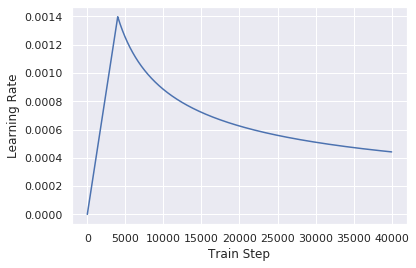

In [24]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.d_model = tf.cast(d_model, tf.float32)
        
        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
    

temp_learning_rate_schedule = CustomSchedule(128)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [25]:
# params and loss etc.
EPOCHS = 20

num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1


# learning things
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

In [26]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size,
                          dropout=dropout_rate)

# transformer.summary()

In [27]:
# masking things
def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)
  
    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)
  
    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by 
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return enc_padding_mask, combined_mask, dec_padding_mask

create_masks(
    tf.constant([[1.0, 2.0, 3.0, 8.9, 9, 9, 10] + [0.0] * 43]),
    tf.constant([[4.0, 5.0, 3.0, 8.9, 9] + [0.0] * 45])
)

(<tf.Tensor: id=213011, shape=(1, 1, 1, 50), dtype=float32, numpy=
 array([[[[0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1., 1.]]]], dtype=float32)>,
 <tf.Tensor: id=213043, shape=(1, 1, 50, 50), dtype=float32, numpy=
 array([[[[0., 1., 1., ..., 1., 1., 1.],
          [0., 0., 1., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.],
          ...,
          [0., 0., 0., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.]]]], dtype=float32)>,
 <tf.Tensor: id=213018, shape=(1, 1, 1, 50), dtype=float32, numpy=
 array([[[[0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1., 1.]]]], dtyp

In [28]:
# loss things
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
  
    return tf.reduce_mean(loss_)


loss_function(np.array([1]), np.array([[0.0, 1e9, 0.0, 0.0]])), \
loss_function(np.array([2]), np.array([[0.0, 1e9, 0.0, 0.0]]))

(<tf.Tensor: id=213070, shape=(), dtype=float64, numpy=0.0>,
 <tf.Tensor: id=213097, shape=(), dtype=float64, numpy=1000000000.0>)

In [29]:
loss_function(
    np.array([1, 2, 0, 0]),
    np.array([
        [0.0, 1e9, 0.0, 0.0],
        [0.0, 0.0, 1e9, 0.0],
        [0.0, 1e9, 0.0, 0.0],
        [0.0, 0.0, 0.0, 1e9]
    ])
)

<tf.Tensor: id=213124, shape=(), dtype=float64, numpy=0.0>

In [30]:
# checkpoints and training steps

checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')
    

# training stuff
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

@tf.function(input_signature=[
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
])
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
  
    enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                     True, 
                                     enc_padding_mask, 
                                     look_ahead_mask, 
                                     dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
    train_loss(loss)
    train_accuracy(tar_real, predictions)

    
# training
for epoch in range(EPOCHS):
    start = time.time()
    
    train_loss.reset_states()
    train_accuracy.reset_states()
    
    # inp -> portuguese, tar -> english
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)
        
        if batch % 50 == 0:
            print(f"Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}")
    
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print(f"Checkpoint saved for epoch {epoch} at {ckpt_save_path}")
        
    print(f"Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}")
    print(f"Time taken for 1 epoch: {time.time() - start} secs\n")

Epoch 1 Batch 0 Loss 4.2999 Accuracy 0.0000
Epoch 1 Batch 50 Loss 4.1999 Accuracy 0.0003
Epoch 1 Batch 100 Loss 4.1674 Accuracy 0.0103
Epoch 1 Batch 150 Loss 4.1378 Accuracy 0.0151
Epoch 1 Batch 200 Loss 4.0638 Accuracy 0.0175
Epoch 1 Batch 250 Loss 3.9896 Accuracy 0.0209
Epoch 1 Batch 300 Loss 3.9169 Accuracy 0.0258
Epoch 1 Batch 350 Loss 3.8353 Accuracy 0.0296
Epoch 1 Batch 400 Loss 3.7488 Accuracy 0.0326
Epoch 1 Batch 450 Loss 3.6728 Accuracy 0.0354
Epoch 1 Batch 500 Loss 3.6013 Accuracy 0.0384
Epoch 1 Batch 550 Loss 3.5373 Accuracy 0.0418
Epoch 1 Batch 600 Loss 3.4804 Accuracy 0.0455
Epoch 1 Batch 650 Loss 3.4235 Accuracy 0.0491
Epoch 1 Batch 700 Loss 3.3728 Accuracy 0.0526
Epoch 1 Loss 3.3710 Accuracy 0.0527
Time taken for 1 epoch: 568.6343777179718 secs

Epoch 2 Batch 0 Loss 2.5240 Accuracy 0.0917
Epoch 2 Batch 50 Loss 2.5372 Accuracy 0.1020
Epoch 2 Batch 100 Loss 2.5430 Accuracy 0.1050
Epoch 2 Batch 150 Loss 2.5252 Accuracy 0.1072
Epoch 2 Batch 200 Loss 2.4960 Accuracy 0.1089
Ep

Epoch 11 Batch 400 Loss 0.8517 Accuracy 0.2988
Epoch 11 Batch 450 Loss 0.8545 Accuracy 0.2988
Epoch 11 Batch 500 Loss 0.8569 Accuracy 0.2990
Epoch 11 Batch 550 Loss 0.8590 Accuracy 0.2989
Epoch 11 Batch 600 Loss 0.8600 Accuracy 0.2991
Epoch 11 Batch 650 Loss 0.8607 Accuracy 0.2987
Epoch 11 Batch 700 Loss 0.8627 Accuracy 0.2987
Epoch 11 Loss 0.8632 Accuracy 0.2987
Time taken for 1 epoch: 419.46967220306396 secs

Epoch 12 Batch 0 Loss 0.7577 Accuracy 0.3211
Epoch 12 Batch 50 Loss 0.7872 Accuracy 0.3101
Epoch 12 Batch 100 Loss 0.7767 Accuracy 0.3082
Epoch 12 Batch 150 Loss 0.7864 Accuracy 0.3108
Epoch 12 Batch 200 Loss 0.7861 Accuracy 0.3095
Epoch 12 Batch 250 Loss 0.7907 Accuracy 0.3091
Epoch 12 Batch 300 Loss 0.7929 Accuracy 0.3084
Epoch 12 Batch 350 Loss 0.7950 Accuracy 0.3085
Epoch 12 Batch 400 Loss 0.7992 Accuracy 0.3082
Epoch 12 Batch 450 Loss 0.7994 Accuracy 0.3079
Epoch 12 Batch 500 Loss 0.8017 Accuracy 0.3076
Epoch 12 Batch 550 Loss 0.8039 Accuracy 0.3071
Epoch 12 Batch 600 Loss 

In [31]:
# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

transformer.summary()

Latest checkpoint restored!!
Model: "transformer_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_2 (Encoder)          multiple                  1844736   
_________________________________________________________________
decoder_2 (Decoder)          multiple                  2093696   
_________________________________________________________________
dense_151 (Dense)            multiple                  1043481   
Total params: 4,981,913
Trainable params: 4,981,913
Non-trainable params: 0
_________________________________________________________________


In [33]:
def evaluate(inp_sentence):
    start_token = [tokenizer_pt.vocab_size]
    end_token = [tokenizer_pt.vocab_size + 1]
  
    # inp sentence is portuguese, hence adding the start and end token
    inp_sentence = start_token + tokenizer_pt.encode(inp_sentence) + end_token
    encoder_input = tf.expand_dims(inp_sentence, 0)
  
    # as the target is english, the first word to the transformer should be the
    # english start token.
    decoder_input = [tokenizer_en.vocab_size]
    output = tf.expand_dims(decoder_input, 0)
    
    for i in range(MAX_LENGTH):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            encoder_input,
            output)
  
        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input, 
                                                     output,
                                                     False,
                                                     enc_padding_mask,
                                                     combined_mask,
                                                     dec_padding_mask)
    
        # select the last word from the seq_len dimension
        predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
        # return the result if the predicted_id is equal to the end token
        if predicted_id == tokenizer_en.vocab_size+1:
            return tf.squeeze(output, axis=0), attention_weights
    
        # concatentate the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights


evaluate("este é um problema que temos que resolver.")[0]

<tf.Tensor: id=559773, shape=(22,), dtype=int32, numpy=
array([8087,   16,   13,    7,  328,   10,   14,   24,    5,  821,   28,
         13,   14,  195,  966,    7,  328,   28,   43,  423,  223,    2],
      dtype=int32)>

In [59]:
def plot_attention_weights(attention, sentence, result, layer=None, block=None):
    fig = plt.figure(figsize=(16, 8))
    sentence = tokenizer_pt.encode(sentence)
    attention = tf.squeeze(attention[layer][block], axis=0)

    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head+1)
    
        # plot the attention weights
        ax.matshow(attention[head][:-1, :], cmap='viridis')

        fontdict = {'fontsize': 10}
    
        ax.set_xticks(range(len(sentence)+2))
        ax.set_yticks(range(len(result)))
    
        ax.set_ylim(len(result)-1.5, -0.5)
        
        ax.set_xticklabels(
            ['<start>']+[tokenizer_pt.decode([i]) for i in sentence]+['<end>'], 
            fontdict=fontdict, rotation=90)
    
        ax.set_yticklabels([tokenizer_en.decode([i])
                            for i in result 
                            if i < tokenizer_en.vocab_size], 
                            fontdict=fontdict)
    
        ax.set_xlabel('Head {}'.format(head+1))
  
    plt.tight_layout()
    plt.show()

    
def translate(sentence, layer=None, block=None):
    result, attention_weights = evaluate(sentence)
    predicted_sentence = tokenizer_en.decode([i for i in result 
                                              if i < tokenizer_en.vocab_size])  

    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(predicted_sentence))
  
    if layer and block:
        plot_attention_weights(attention_weights, sentence, result, layer=layer, block=block)


translate("este é um problema que temos que resolver.")
print("Real translation: this is a problem we have to solve .")

Input: este é um problema que temos que resolver.
Predicted translation: this is a problem that we have to deal with is we should solve a problem with our kids today .
Real translation: this is a problem we have to solve .


In [60]:
translate("os meus vizinhos ouviram sobre esta ideia.")
print("Real translation: and my neighboring homes heard about this idea .")


Input: os meus vizinhos ouviram sobre esta ideia.
Predicted translation: my neighbors heard about this idea .
Real translation: and my neighboring homes heard about this idea .


In [61]:
translate("vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.")
print ("Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .")

Input: vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Predicted translation: so i 'm very quickly to share with you some little magic stories that happened .
Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .


Input: este é o primeiro livro que eu fiz.
Predicted translation: this is the first book that i did was done .


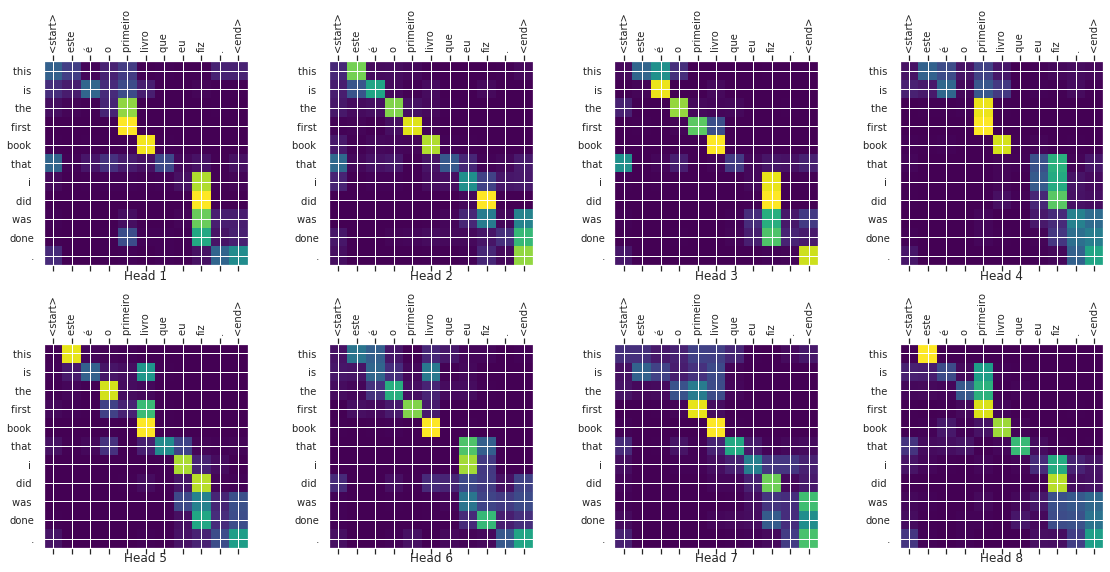

Real translation: this is the first book i've ever done.


In [62]:
translate("este é o primeiro livro que eu fiz.", layer=4, block='block2')
print ("Real translation: this is the first book i've ever done.")